In [1]:
import agate
text = agate.Text()
number = agate.Number()
mean_temps = agate.Table.from_csv('mon_temps_lnk.csv')

In [2]:
print(mean_temps)
mon_averages = {'JAN':24.6, 'FEB':29,'MAR':40.1,'APR':51.6,'MAY':62.3,'JUN':72.6,'JUL':77.6,'AUG':75.3,'SEP':66,'OCT':53.2,'NOV':38.9,'DEC':26.8,'Annual':51.6}
mon_temps = mean_temps.where(lambda row: row['Year'] != 'Averages')
print(len(mon_temps.rows))
mon_temps.print_table(50)

|---------------+---------------|
|  column_names | column_types  |
|---------------+---------------|
|  Year         | Text          |
|  JAN          | Number        |
|  FEB          | Number        |
|  MAR          | Number        |
|  APR          | Number        |
|  MAY          | Number        |
|  JUN          | Number        |
|  JUL          | Number        |
|  AUG          | Number        |
|  SEP          | Number        |
|  OCT          | Number        |
|  NOV          | Number        |
|  DEC          | Number        |
|  Annual       | Number        |
|---------------+---------------|

129
|-------+------+------+------+------+------+------+------+------+------+------+------+------+---------|
|  Year |  JAN |  FEB |  MAR |  APR |  MAY |  JUN |  JUL |  AUG |  SEP |  OCT |  NOV |  DEC | Annual  |
|-------+------+------+------+------+------+------+------+------+------+------+------+------+---------|
|  2015 | 28.1 | 21.6 | 43.3 | 54.0 | 61.5 | 73.4 | 77.1 | 73.8 | 71.4 

In [3]:

from decimal import Decimal
class differenceAverage(agate.Computation):
    """
    Calculates the difference between normal and each monthly
    """
    def __init__(self, month, monthDict):
        self._month = month
        self._monthDict = monthDict

    def get_computed_data_type(self, table):
        """
        The return value is a number.
        """
        return agate.Number()

    def validate(self, table):
        """
        Verify the column is a number.
        """
        column = table.columns[self._month]

        if not isinstance(column.data_type, agate.Number):
            raise agate.DataTypeError('Can only be applied to number data.')

    def run(self, table):
        new_column = []    
        for row in table.rows:
            current = row[self._month]
            normal = self._monthDict[self._month]
            normal_decimal = Decimal(normal)
            diff = current - normal_decimal
            new_column.append(diff.quantize(Decimal('0.01')))
        return new_column

In [11]:
computations = []
for month in mon_averages.keys():
    print(month)
    value = differenceAverage(month, mon_averages)
    computations.append(('diff_{}'.format(month), value))
new_table = mon_temps.compute(computations)
new_table.print_table()
tables_diff = new_table.select(['Year','diff_Annual'])

SEP
OCT
FEB
APR
JUN
Annual
MAY
AUG
NOV
MAR
JUL
DEC
JAN
|-------+------+------+------+------+------+------+------+------+------+------+------+------+--------+----------+----------+----------+----------+----------+-------------+----------+----------+----------+----------+----------+----------+-----------|
|  Year |  JAN |  FEB |  MAR |  APR |  MAY |  JUN |  JUL |  AUG |  SEP |  OCT |  NOV |  DEC | Annual | diff_SEP | diff_OCT | diff_FEB | diff_APR | diff_JUN | diff_Annual | diff_MAY | diff_AUG | diff_NOV | diff_MAR | diff_JUL | diff_DEC | diff_JAN  |
|-------+------+------+------+------+------+------+------+------+------+------+------+------+--------+----------+----------+----------+----------+----------+-------------+----------+----------+----------+----------+----------+----------+-----------|
|  2015 | 28.1 | 21.6 | 43.3 | 54.0 | 61.5 | 73.4 | 77.1 | 73.8 | 71.4 | 57.1 | 44.9 | 33.6 |   53.3 |      5.4 |      3.9 |     -7.4 |      2.4 |      0.8 |         1.7 |     -0.8 |     -1.5 |  

In [12]:
tables_diff.print_table()

|-------+--------------|
|  Year | diff_Annual  |
|-------+--------------|
|  2015 |         1.7  |
|  2014 |        -0.5  |
|  2013 |        -1.4  |
|  2012 |         2.9  |
|  2011 |        -0.4  |
|  2010 |        -0.5  |
|  2009 |        -1.6  |
|  2008 |        -1.0  |
|  2007 |         1.0  |
|  2006 |         2.0  |
|  2005 |         1.2  |
|  2004 |         0.2  |
|  2003 |        -0.5  |
|  2002 |         2.3  |
|  2001 |         0.9  |
|  2000 |         0.5  |
|  1999 |         1.1  |
|  1998 |         1.6  |
|  1997 |        -1.0  |
|  1996 |        -2.9  |
|  1995 |        -0.8  |
|  1994 |        -1.1  |
|  1993 |        -3.3  |
|  1992 |         0.2  |
|  1991 |         1.6  |
|  1990 |         1.9  |
|  1989 |        -1.1  |
|  1988 |         1.2  |
|  1987 |         2.6  |
|  1986 |         1.4  |
|  1985 |        -2.4  |
|  1984 |        -0.5  |
|  1983 |        -0.8  |
|  1982 |        -2.3  |
|  1981 |         1.1  |
|  1980 |         0.3  |
|  1979 |        -2.8  |


In [13]:
differences = tables_diff.to_csv('lnkMonths.csv')

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(style="ticks", context='talk', font_scale=1)
%matplotlib inline


In [15]:
df = pd.read_csv('lnkMonths.csv')

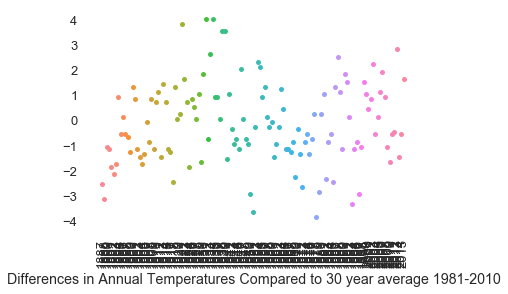

In [17]:
sns.set_style("white")
sns.stripplot(x="Year" , y="diff_Annual", data=df);
plt.ylabel('')
plt.xlabel('Differences in Annual Temperatures Compared to 30 year average 1981-2010')
plt.xticks(rotation=90)
plt.autoscale(tight=True)
#ax = plt.gca()
#ax.get_xticks().get_major_formatter().scaled[365] = '%y'
sns.despine(bottom=True, left=True)